In [1]:
import sys, time, math
from collections import Counter

In [2]:
lines = open("dssp-dataset-1.txt", 'r').readlines()
state = 0
Ls = []
ct = Counter("")
st = Counter("")
seqs = []
tags = [] 
for l in lines:
    if l[0] == "#": continue
    if l[0] == ">":
        prot = l.strip()[1:]
        state = 1
    elif state == 1:
        seq = l.strip()
        state = 2
    elif state == 2:
        label = l.strip()
        #check sample
        Ls.append(len(seq))
        ct += Counter(seq)
        st += Counter(label)
        seqs.append(seq)
        tags.append(label)
        #print(prot, len(seq), len(label))
        state = 0

(array([ 926.,  982., 1033., 1098., 1030.,  911.,  878.,  811.,  781.,
         658.,  625.,  568.,  577.,  557.,  539.,  503.,  484.,  410.,
         342.,  330.,  335.,  306.,  258.,  214.,  224.,  206.,  198.,
         139.,  145.,  124.,  143.,   89.,   85.,   69.,   63.,   88.,
          73.,   57.,   53.,   47.,   49.,   46.,   32.,   42.,   39.,
          34.,   35.,   29.,   31.,   16.]),
 array([ 80. ,  94.3, 108.6, 122.9, 137.2, 151.5, 165.8, 180.1, 194.4,
        208.7, 223. , 237.3, 251.6, 265.9, 280.2, 294.5, 308.8, 323.1,
        337.4, 351.7, 366. , 380.3, 394.6, 408.9, 423.2, 437.5, 451.8,
        466.1, 480.4, 494.7, 509. , 523.3, 537.6, 551.9, 566.2, 580.5,
        594.8, 609.1, 623.4, 637.7, 652. , 666.3, 680.6, 694.9, 709.2,
        723.5, 737.8, 752.1, 766.4, 780.7, 795. ]),
 <a list of 50 Patch objects>)

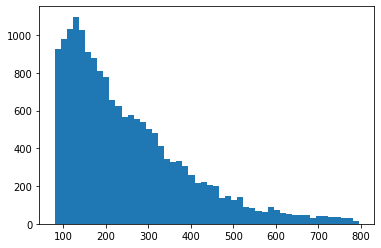

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist([L for L in Ls if L<800], bins=50)

<BarContainer object of 21 artists>

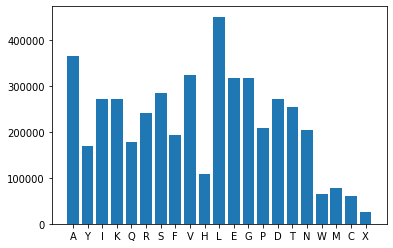

In [4]:
plt.bar(x=ct.keys(),height=ct.values())

<BarContainer object of 3 artists>

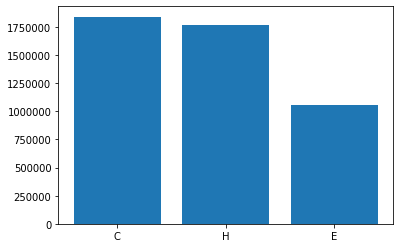

In [5]:
plt.bar(x=st.keys(),height=st.values())

In [6]:
alphabet = "-ACDEFGHIKLMNPQRSTVWYX"
i2c = {i:alphabet[i] for i in range(len(alphabet))}
c2i = {c:i for i,c in i2c.items()}

In [7]:
states = "-CHE"
i2s = {i:states[i] for i in range(len(states))}
s2i = {s:i for i,s in i2s.items()}

## 处理变长data 
数据按长度排序，每个batch内的序列长度相对接近，padding补齐

In [8]:
import numpy as np
import torch
from torch.autograd import Variable
from numpy.random import permutation
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

max_length = 600

#emmbeding
rawX = []
rawY = []
for seq in seqs:
    rawX.append(torch.Tensor([c2i[c] for j,c in enumerate(seq) if j<max_length]))
for tag in tags:
    rawY.append(torch.Tensor([s2i[s] for j,s in enumerate(tag) if j<max_length]))
    
#randomly sorting
idx_sort = permutation(len(Ls))                    
rawX = [rawX[i] for i in idx_sort]
rawY = [rawY[i] for i in idx_sort]

#split
rawX, X_test, rawY, y_test = train_test_split(rawX, rawY, test_size=0.2, random_state=42)

#sort validation set, similar length in each batch
Lt = [len(d) for d in rawX]
idx_sort = np.argsort(Lt) #shuffle
rawX = [rawX[i] for i in idx_sort]
rawY = [rawY[i] for i in idx_sort]

Lv = [len(d) for d in X_test]
idx_sort = np.argsort(Lv) #shuffle
X_test = [X_test[i] for i in idx_sort]
y_test = [y_test[i] for i in idx_sort]

In [9]:
print(len(rawX), len(X_test))

14086 3522


In [10]:
from torch.nn import utils as nn_utils
import torch.nn.utils.rnn as rnn_utils
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, sequence, target):
        self.sequence = sequence
        self.target = target
        
    def __len__(self):
        return len(self.sequence)
    
    def __getitem__(self, item):
        return self.sequence[item], self.target[item]
    
def collate_fn(data):
    data.sort(key=lambda x: len(x[0]), reverse=True)
    length = [len(x[0]) for x in data]
    X = rnn_utils.pad_sequence([x[0] for x in data], batch_first=True, padding_value=0)
    y = rnn_utils.pad_sequence([x[1] for x in data], batch_first=True, padding_value=0)
    return X, y, length

train_data = Dataset(rawX,rawY)
train_dataloader = data.DataLoader(train_data, batch_size=500, collate_fn=collate_fn)

val_data = Dataset(X_test, y_test)
val_dataloader = data.DataLoader(val_data, batch_size=125, collate_fn=collate_fn)

In [11]:
def one_hot(x, n_class, dtype=torch.float32): 
    # X shape: (batch), output shape: (batch, n_class)
    x = x.long()
    res = torch.zeros(x.shape[0], n_class, dtype=dtype, device=x.device)
    res.scatter_(1, x.view(-1, 1), 1)
    return res

def to_onehot(X, n_class):  
    # X shape: (batch, seq_len), output: seq_len elements of (batch, n_class)
    return [one_hot(X[:, i], n_class) for i in range(X.shape[1])]

def grad_clipping(params, theta, device):
    norm = torch.tensor([0.0], device=device)
    for param in params:
        norm += (param.grad.data ** 2).sum()
    norm = norm.sqrt().item()
    if norm > theta:
        for param in params:
            param.grad.data *= (theta / norm)

In [12]:
#model
from torch import nn, optim
vocab_size = 22
num_hiddens = 32
state_num = 4
bidiret = True

rnn_layer = nn.LSTM(input_size=vocab_size, hidden_size=num_hiddens, bidirectional=bidiret)
#rnn_layer = nn.RNN(input_size=vocab_size, hidden_size=num_hiddens, bidirectional=bidiret)

class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, state_num):
        super(RNNModel, self).__init__()
        self.rnn = rnn_layer
        self.hidden_size = rnn_layer.hidden_size * (2 if rnn_layer.bidirectional else 1) 
        self.vocab_size = vocab_size
        self.state_num = state_num
        self.dense = nn.Linear(self.hidden_size, state_num)
        self.state = None

    def forward(self, inputs, state): # inputs: (batch, seq_len)
        # 获取one-hot向量表示
        X = to_onehot(inputs, self.vocab_size) # X是个list
        X = torch.stack(X)
        Y, self.state = self.rnn(X, state)
        # 全连接层会首先将Y的形状变成(num_steps * batch_size, num_hiddens)，它的输出
        # 形状为(num_steps * batch_size, vocab_size)
        output = self.dense(Y.view(-1, Y.shape[-1]))
        #output = self.dense(Y)
        return output, self.state

In [13]:
model = RNNModel(rnn_layer, vocab_size, state_num)

In [14]:
max_epochs = 500
lr = 0.004
clipping_theta = 0.002

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model.to(device)

lstP = []
valP = []

for epoch in range(max_epochs):
    l_sum, n, start = 0.0, 0, time.time()
    lv_sum, nv = 0.0, 0
    
    #trainning
    for b_X, b_y, length in train_dataloader:
        state = None # do not pass to the next batch
        b_X, b_y = b_X.to(device), b_y.to(device)
        
        output, state = model(b_X, state)
        
        b_y = torch.transpose(b_y, 0, 1).contiguous().view(-1)

        loss = loss_fn(output, b_y.long())
        
        optimizer.zero_grad()
        loss.backward()
        grad_clipping(model.parameters(), clipping_theta, device)
        optimizer.step()
        l_sum += loss.item() * b_y.shape[0]
        n += b_y.shape[0]
        
    #validation
    for b_X, b_y, length in val_dataloader:
        state = None # do not pass to the next batch
        b_X, b_y = b_X.to(device), b_y.to(device)
        output, state = model(b_X, state)
        b_y = torch.transpose(b_y, 0, 1).contiguous().view(-1)
        loss = loss_fn(output, b_y.long())
        lv_sum += loss.item() * b_y.shape[0]
        nv += b_y.shape[0]
    
    #report
    try:
        perplexity = math.exp(l_sum / n)
        lstP.append(perplexity)
    except OverflowError:
        perplexity = float('inf')
    
    try:
        vp = math.exp(lv_sum/nv)
        valP.append(vp)
    except OverflowError:
        vp = float('inf')
        
    if (epoch+1) % 10 == 0:
        print('epoch %d, perplexity %f, valp %f, time %.2f sec' % (
                epoch + 1, perplexity, vp, time.time() - start))

epoch 10, perplexity 2.176115, valp 2.161370, time 2.19 sec
epoch 20, perplexity 2.089600, valp 2.078027, time 2.19 sec
epoch 30, perplexity 2.016169, valp 2.010770, time 2.17 sec
epoch 40, perplexity 1.997313, valp 1.995709, time 2.19 sec
epoch 50, perplexity 1.980065, valp 1.979233, time 2.18 sec
epoch 60, perplexity 1.969271, valp 1.969684, time 2.17 sec
epoch 70, perplexity 1.961279, valp 1.964694, time 2.20 sec
epoch 80, perplexity 1.954765, valp 1.959360, time 2.25 sec
epoch 90, perplexity 1.949764, valp 1.955819, time 2.18 sec
epoch 100, perplexity 1.946058, valp 1.954061, time 2.16 sec
epoch 110, perplexity 1.941790, valp 1.949351, time 2.18 sec
epoch 120, perplexity 1.937187, valp 1.945888, time 2.19 sec
epoch 130, perplexity 1.933341, valp 1.943029, time 2.18 sec
epoch 140, perplexity 1.930222, valp 1.941154, time 2.16 sec
epoch 150, perplexity 1.927784, valp 1.939774, time 2.18 sec
epoch 160, perplexity 1.933889, valp 1.947355, time 2.18 sec
epoch 170, perplexity 1.925788, v

(1.8, 2.0)

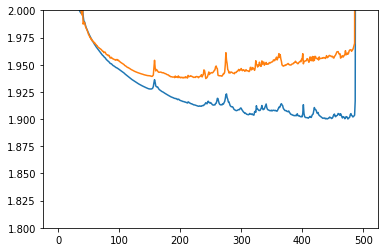

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(lstP)
plt.plot(valP)
plt.ylim([1.8,2.0])

## shuffle, lr=0.002, clip=0.001, bidi=False, batch=500
baseline num_hiddens = 16, train=2.351, val=2,354

baseline num_hiddens = 32, train=2.328, val=2.330

baseline num_hiddens = 64, train=2.305, val=2.317

## shuffle, lr=0.002, clip=0.001, bidi=True, batch=500

baseline num_hiddens = 16, train=2.000, val=1.994

baseline num_hiddens = 32, train=1.980, val=1.978

baseline num_hiddens = 64, train=1.951, val=1.974


## shuffle, lr=0.004, clip=0.002, LSTM, bi=F, batch=500

baseline num_hiddens = 16, train=2.299, val=2.309

baseline num_hiddens = 32, train=2.272, val=2.298

baseline num_hiddens = 64, train=2.263, val=2.287

## shuffle, lr=0.004, clip=0.004, LSTM, bi=T, batch=500

baseline num_hiddens = 24, train=1.924, val=1.952

**baseline num_hiddens = 32, train=1.91, val=1.941 --270**

baseline num_hiddens = 48, train=1.90, val=1.941 --160

baseline num_hiddens = 64, train=1.90, val=1.94? --90

In [ ]:
#how to prevent updating after <EOF>